In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from pathlib import Path
from dynamiqs import wigner
import jax.numpy as jnp

In [70]:
def load_and_visualize_states(file_path):
    """
    Loads a Quantum-State-Pickle file and visualize the corresponding Wigner function
    """
    data_path = Path(file_path)
    
    if not data_path.exists():
        print(f"Verzeichnis {file_path} existiert nicht!")
        return
    
    try:
        print(f"\nLade Datei: {file_path}")
        with open(file_path, 'rb') as f:
            state = pickle.load(f)
            wigner_function = wigner(state)
            plt.contourf(wigner_function[0], wigner_function[1], wigner_function[2],levels=100, cmap='seismic', vmax=np.pi/2, vmin=-np.pi/2)
            plt.colorbar()
            plt.tight_layout()
            plt.show()
        
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file_path}: {e}")

In [71]:
def compute_wigner_function(file_path):
    """
    Lädt alle Quantum-State Pickle-Dateien aus dem angegebenen Verzeichnis und visualisiert sie.
    """
    data_path = Path(file_path)
    
    if not data_path.exists():
        print(f"Verzeichnis {file_path} existiert nicht!")
        return
    
    try:
        print(f"Lade Datei: {file_path}")
        with open(file_path, 'rb') as f:
            state = pickle.load(f)
            wigner_function = wigner(state)
            return wigner_function
        
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file_path}: {e}")


Lade Datei: ../../../data/synthetic/quantum_state_1.pickle


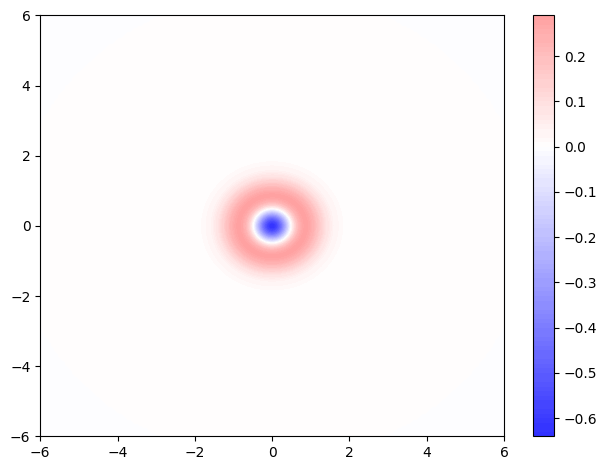

In [72]:
file_path = "../../../data/synthetic/quantum_state_1.pickle"
load_and_visualize_states(file_path) 

In [55]:
# Compute the Wigner function
file_path = "../../../data/synthetic/quantum_state_1.pickle"
wigner_fct = compute_wigner_function(file_path) 

Lade Datei: ../../../data/synthetic/quantum_state_1.pickle


In [101]:
def uniform_displacement_sampling(wigner_fct, n_samples=200, threshold_factor=0.2):
    """
    Performs uniform sampling of the Wigner function.
    
    Parameters:
    -----------
    wigner_fct : tuple
        The Wigner function as a tuple (x_grid, p_grid, w_values)
    n_samples : int
        Number of points to sample
    threshold_factor : float
        Factor for threshold values
        
    Returns:
    --------
    alpha_k : numpy.ndarray
        Complex values of the sampled points
    alpha_k_x : numpy.ndarray
        x-components of the sampled points
    alpha_k_p : numpy.ndarray
        p-components of the sampled points
    """
    # Find the maximum of the Wigner function
    max_value = np.max(wigner_fct[2])
    max_pos = np.where(wigner_fct[2] == max_value)  
    x_max = wigner_fct[0][max_pos[0][0]] 
    p_max = wigner_fct[1][max_pos[1][0]]
    print(f"Maximum der Wigner-Funktion: {max_value}")
    print(f"Position des Maximums: x = {x_max}, p = {p_max}")

    # Shift the grid
    x_grid = wigner_fct[0] - x_max
    p_grid = wigner_fct[1] - p_max
    wigner_fct_shifted = (x_grid, p_grid, wigner_fct[2])

    # Find the minimum of the Wigner function
    min_value = np.min(wigner_fct[2])
    min_pos = np.where(wigner_fct[2] == min_value)  
    x_min = wigner_fct[0][min_pos[0][0]] 
    p_min = wigner_fct[1][min_pos[1][0]]
    print(f"Minimum der Wigner-Funktion: {min_value}")
    print(f"Position des Minimums: x = {x_min}, p = {p_min}")

    # Define thresholds
    threshold_max = threshold_factor * max_value  
    threshold_min = threshold_factor * min_value - 0.1

    # Create mask for sampling
    mask = (wigner_fct_shifted[2] >= threshold_max) | (wigner_fct_shifted[2] <= threshold_min)
    rows, cols = np.where(mask)
    x_sampled = x_grid[rows]
    p_sampled = p_grid[cols]
    w_sampled = wigner_fct_shifted[2][mask]

    # Uniformes Sampling
    indices = np.random.choice(len(x_sampled), n_samples, replace=False)
    alpha_k_x = x_sampled[indices]
    alpha_k_p = p_sampled[indices]

    print(f"Number of points sampled: {len(alpha_k_x)}")
    
    alpha_k = [(x, p) for x, p in zip(alpha_k_x, alpha_k_p)]
    return alpha_k

In [ ]:
def radial_displacement_sampling(wigner_fct, n_samples=200, threshold_factor=0.2):
    """
    Performs radial sampling of the Wigner function. We draw the x and p coordinates both independently from a normal distribution
    
    Parameters:
    -----------
    wigner_fct : tuple
        The Wigner function as a tuple (x_grid, p_grid, w_values)
    n_samples : int
        Number of points to sample
    threshold_factor : float
        Factor for threshold values
        
    Returns:
    --------
    alpha_k : numpy.ndarray
        Complex values of the sampled points
    alpha_k_x : numpy.ndarray
        x-components of the sampled points
    alpha_k_p : numpy.ndarray
        p-components of the sampled points
    """
    # Find the maximum of the Wigner function
    max_value = np.max(wigner_fct[2])
    max_pos = np.where(wigner_fct[2] == max_value)  
    x_max = wigner_fct[0][max_pos[0][0]] 
    p_max = wigner_fct[1][max_pos[1][0]]
    print(f"Maximum der Wigner-Funktion: {max_value}")
    print(f"Position des Maximums: x = {x_max}, p = {p_max}")

    # Shift the grid
    x_grid = wigner_fct[0] - x_max
    p_grid = wigner_fct[1] - p_max
    wigner_fct_shifted = (x_grid, p_grid, wigner_fct[2])

    # Find the minimum of the Wigner function
    min_value = np.min(wigner_fct[2])
    min_pos = np.where(wigner_fct[2] == min_value)  
    x_min = wigner_fct[0][min_pos[0][0]] 
    p_min = wigner_fct[1][min_pos[1][0]]
    print(f"Minimum der Wigner-Funktion: {min_value}")
    print(f"Position des Minimums: x = {x_min}, p = {p_min}")

    # Define thresholds
    threshold_max = threshold_factor * max_value  
    threshold_min = threshold_factor * min_value - 0.1

    # Create mask for sampling
    mask = (wigner_fct_shifted[2] >= threshold_max) | (wigner_fct_shifted[2] <= threshold_min)
    rows, cols = np.where(mask)
    x_sampled = x_grid[rows]
    p_sampled = p_grid[cols]
    w_sampled = wigner_fct_shifted[2][mask]

    # Uniformes Sampling
    indices = np.random.choice(len(x_sampled), n_samples, replace=False)
    alpha_k_x = x_sampled[indices]
    alpha_k_p = p_sampled[indices]

    print(f"Number of points sampled: {len(alpha_k_x)}")
    
    alpha_k = [(x, p) for x, p in zip(alpha_k_x, alpha_k_p)]
    return alpha_k

Maximum der Wigner-Funktion: 0.2840973138809204
Position des Maximums: x = -0.720000147819519, p = -0.4800001382827759
Minimum der Wigner-Funktion: -0.6366197466850281
Position des Minimums: x = 0.0, p = 0.0
Number of points sampled: 200
Maximum der Wigner-Funktion: 0.2840973138809204
Position des Maximums: x = -0.720000147819519, p = -0.4800001382827759
Minimum der Wigner-Funktion: -0.6366197466850281
Position des Minimums: x = 0.0, p = 0.0
Number of points sampled: 200


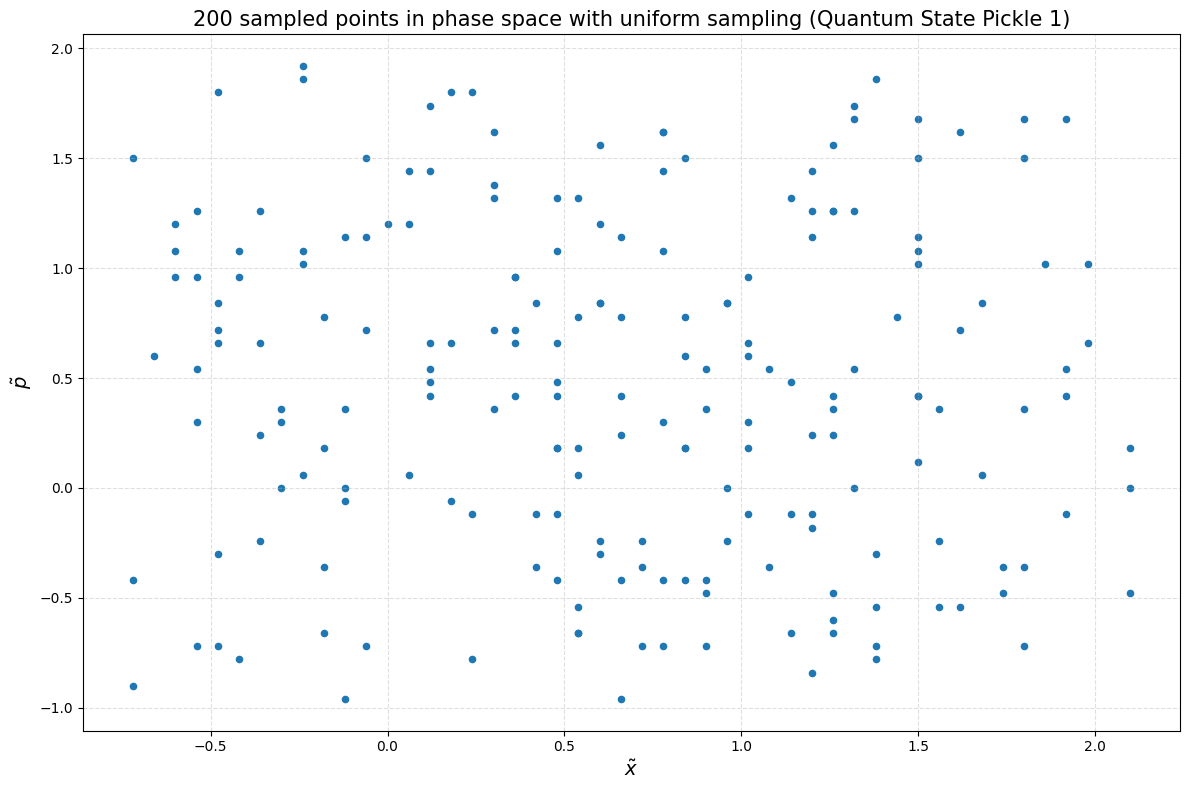

In [102]:
# Scatterplot of the selected points
plt.figure(figsize=(12, 8))
# Extrahiere x und p Komponenten aus alpha_k
alpha_k_x = [point[0] for point in uniform_displacement_sampling(wigner_fct)]
alpha_k_p = [point[1] for point in uniform_displacement_sampling(wigner_fct)]
plt.scatter(alpha_k_x, alpha_k_p, s=20)
plt.xlabel(r"$\tilde{x}$", fontsize=14)
plt.ylabel(r"$\tilde{p}$", fontsize=14)
plt.title("200 sampled points in phase space with uniform sampling (Quantum State Pickle 1)", fontsize=15)
#plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig('../../../images/200_uniformsampled_points_phase_space.png', dpi=300, bbox_inches='tight')

plt.show()

In [100]:
def fit_density_matrix(w_k, E_alpha_k, N):
    """
    Fits a density matrix using convex optimization.
    
    Parameters:
    -----------
    w_k : array-like
        List of observed measurement values
    E_alpha_k : array-like
        Measurement operators
    N : int
        Dimension of the density matrix
        
    Returns:
    --------
    rho_optimal : numpy.ndarray
        The optimized density matrix
    """
    K = len(w_k)
    
    # Define the variable for the density matrix
    rho = cp.Variable((N, N), symmetric=True)
    
    # Define the objective function using least-squares error
    objective = cp.Minimize(sum((cp.trace(E_alpha_k @ rho) - w_k[k])**2 for k in range(K)))
    
    # Define the two constraints for the density matrix
    constraints = [rho >> 0, cp.trace(rho) == 1]
    
    # Formulate and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return rho.value

In [ ]:
rho_optimal = fit_density_matrix(w_k, E_alpha_k, N)
print("Optimal density matrix ρ:")
print(rho_optimal)